# OLED Optimization with FourierFields


In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Al as ALU

mp.verbosity(0)

GLS = mp.Medium(index=1.5)    # 글래스의 굴절률 설정
ITO = mp.Medium(index=1.2)    # ITO의 굴절률 설정
ORG = mp.Medium(index=1.75)   # OLED 유기층의 굴절률 설정
SiN = mp.Medium(index=1.9)    # 실리콘 질화물의 굴절률 설정

Basic setup

In [2]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.8       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 25             # 추출할 주파수 개수
design_region_resolution = 50                                                             

tABS = 0.5    # X/Y 방향 흡수 경계층 두께
tPML = 0.5    # Z 방향 PML 경계층 두께
tGLS = 0.5    # 글래스 층 두께
tITO = 0.5    # ITO 층 두께
tORG = 0.5    # 유기층(OLED 발광층) 두께
tALU = 0.2    # 알루미늄(캐소드) 두께

L = 1.0       # OLED의 가로/세로 길이

design_region_width = L
design_region_height = 0.2

Sy = tPML + tGLS + design_region_height + tITO + tORG + tALU  # Z 방향 전체 길이
Sx = L + 2*tABS                        # X/Y 방향 길이
cell_size = mp.Vector3(Sx, Sy)    # 시뮬레이션 셀 크기

boundary_layers = [mp.Absorber(tABS,direction=mp.X),
                   mp.PML(tPML,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), GLS, SiN, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(y=0.5*Sy - tPML - tGLS - 0.5*design_region_height),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=design_variables,      # 디자인 영역
             size=design_region.size,
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
src_num = 3

for i in range(src_num):  # x 방향 루프
        sources.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )

sim = []

for i in range(src_num):
    sim.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[sources[i]],
                      extra_materials=[ALU],)
    )

                    

<Axes: xlabel='X', ylabel='Y'>

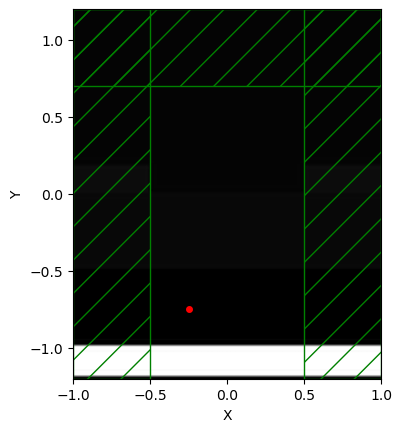

In [3]:
sim[0].plot2D()

<Axes: xlabel='X', ylabel='Y'>

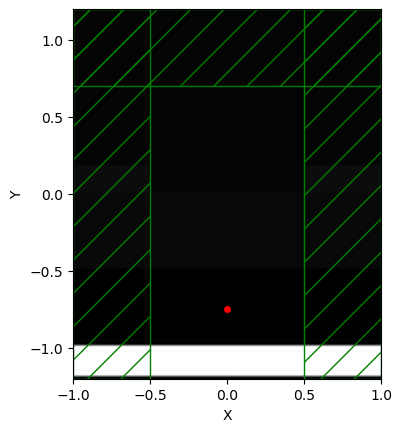

In [4]:
sim[1].plot2D()

<Axes: xlabel='X', ylabel='Y'>

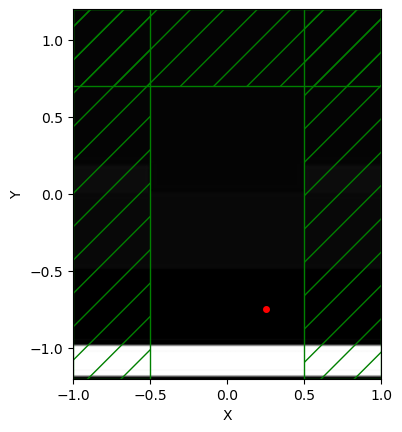

In [5]:
sim[2].plot2D()

In [6]:
monitor_position, monitor_size = mp.Vector3(0,0.5*Sy-tPML-(tGLS-0.05)), mp.Vector3(L,0)

FourierFields = []
for i in range(src_num):
    FourierFields.append(mpa.FourierFields(sim[i],mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True))
ob_list = []
for i in range(src_num):
    ob_list.append([FourierFields[i]])

def J(fields):
    return npa.mean(npa.abs(fields[:,:]) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = []
for i in range(src_num):
    opt.append(mpa.OptimizationProblem(
        simulation=sim[i],
        objective_functions=[J],
        objective_arguments=ob_list[i],
        design_regions=[design_region],
        frequencies=[fcen],
        maximum_run_time=100,
    ))

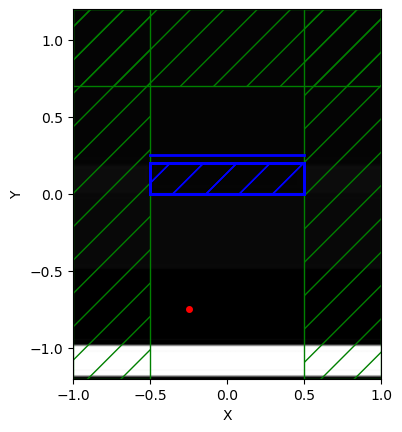

In [7]:
opt[0].plot2D(True)

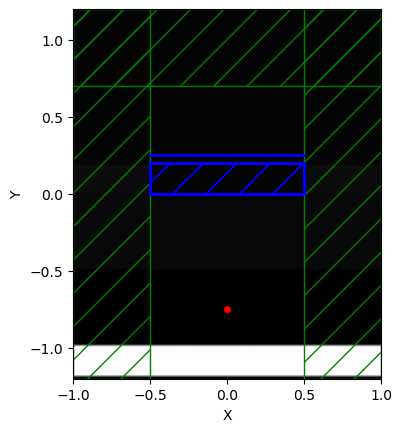

In [8]:
opt[1].plot2D(True)

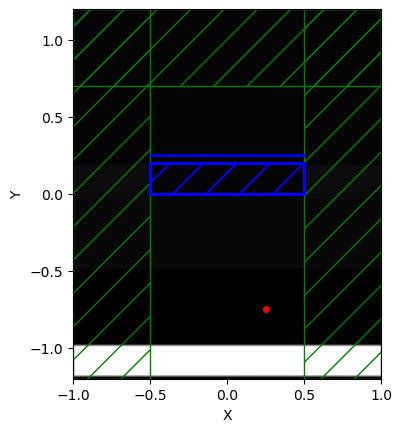

In [9]:
opt[2].plot2D(True)

In [10]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

In [11]:
def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # # projection
    # projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return x

In [12]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0 = []
    dJ_du = []

    for i in range(src_num):
        f0_i, dJ_du_i = opt[i]([mapping(v, eta_i, beta)])
        f0.append(f0_i)
        dJ_du.append(dJ_du_i)

    f0 = np.array(f0)

    print("FoM: {}".format(np.real(f0[0])))
    print("FoM: {}".format(np.real(f0[1])))
    print("FoM: {}".format(np.real(f0[2])))
    print(dJ_du[0].shape)
    print(dJ_du[1].shape)   
    print(dJ_du[2].shape)


    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=0),  # sum the gradients from all sources
        )  # backprop

    print(gradient.shape)

    evaluation_history.append(np.real(np.mean(f0)))

    print("First mean FoM: {}".format(evaluation_history[0]))
    print("Current mean FoM: {}".format(np.real(np.mean(f0))))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(np.mean(f0))

In [13]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 9
update_factor = 12
ftol = 1e-5
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration: 1
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08712234753707157
FoM: 0.09012056967309394
FoM: 0.08712234753707157
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0881217549157457
Current iteration: 2
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.0871286960108107
FoM: 0.09012799539042855
FoM: 0.08712869601081072
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08812846247068333
Current iteration: 3
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08713302511872698
FoM: 0.09013305984842161
FoM: 0.087133025118727
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08813303669529186
Current iteration: 4
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08713597706362314
FoM: 0.0901365135711277
FoM: 0.08713597706362315
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.088136155899458
Current iteration: 5
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08713798988364455
FoM: 0.09013886869969101
FoM: 0.08713798988364456
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0881382828223267
Current iteration: 6
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08713936232146939
FoM: 0.09014047461679667
FoM: 0.08713936232146942
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08813973308657848
Current iteration: 7
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.0871402981026371
FoM: 0.09014156962887239
FoM: 0.08714029810263711
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08814072194471555
Current iteration: 8
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08714093614828945
FoM: 0.09014231625987346
FoM: 0.08714093614828944
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08814139618548411
Current iteration: 9
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08714137030670625
FoM: 0.09014282534125354
FoM: 0.08714137030670624
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08814185531822201
Current iteration: 10
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08714166675508442
FoM: 0.09014317223001837
FoM: 0.08714166675508443
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08814216858006241
Current iteration: 11
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08714186887615817
FoM: 0.09014340874345113
FoM: 0.08714186887615816
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08814238216525583
Current iteration: 12
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08714200668377242
FoM: 0.09014357000079962
FoM: 0.08714200668377241
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08814252778944814
Current iteration: 13
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08714200668377242
FoM: 0.09014357000079962
FoM: 0.08714200668377241
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08814252778944814
Current iteration: 14
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08714835719046403
FoM: 0.09015100191701203
FoM: 0.08714835719046406
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08814923876598003
Current iteration: 15
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08715268847422082
FoM: 0.09015607050163345
FoM: 0.08715268847422078
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08815381581669168
Current iteration: 16
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08715564125244774
FoM: 0.09015952717007532
FoM: 0.08715564125244776
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08815693655832361
Current iteration: 17
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08715765464084659
FoM: 0.09016188430778764
FoM: 0.08715765464084657
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08815906452982693
Current iteration: 18
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08715902746629325
FoM: 0.09016349159508984
FoM: 0.08715902746629327
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08816051550922545
Current iteration: 19
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08715996351179128
FoM: 0.09016458754154033
FoM: 0.0871599635117913
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08816150485504097
Current iteration: 20
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08716060173768873
FoM: 0.0901653348096848
FoM: 0.08716060173768876
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0881621794283541
Current iteration: 21
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08716103689776071
FoM: 0.09016584432551314
FoM: 0.08716103689776071
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08816263937367819
Current iteration: 22
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08716133360060928
FoM: 0.09016619172954324
FoM: 0.08716133360060932
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0881629529769206
Current iteration: 23
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.0871615358992982
FoM: 0.09016642859911234
FoM: 0.0871615358992982
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08816316679923625
Current iteration: 24
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08716167383081683
FoM: 0.09016659010256452
FoM: 0.08716167383081681
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08816331258806605
Current iteration: 25
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08716167383081683
FoM: 0.09016659010256452
FoM: 0.08716167383081681
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08816331258806605
Current iteration: 26
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08716802559357827
FoM: 0.09017402814686207
FoM: 0.08716802559357828
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08817002644467287
Current iteration: 27
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08717235694577936
FoM: 0.09017910101587846
FoM: 0.08717235694577936
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08817460496914574
Current iteration: 28
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08717531042169349
FoM: 0.09018256047629336
FoM: 0.08717531042169348
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08817772710656012
Current iteration: 29
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08717732428597391
FoM: 0.0901849195182892
FoM: 0.08717732428597397
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08817985603007904
Current iteration: 30
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08717869743597188
FoM: 0.09018652810427585
FoM: 0.08717869743597186
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08818130765873987
Current iteration: 31
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08717963370279497
FoM: 0.0901876249363369
FoM: 0.08717963370279497
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08818229744730895
Current iteration: 32
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08718027207961465
FoM: 0.0901883728083736
FoM: 0.08718027207961462
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08818297232253429
Current iteration: 33
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08718070734259675
FoM: 0.09018888273597778
FoM: 0.08718070734259675
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08818343247372377
Current iteration: 34
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08718100411561547
FoM: 0.09018923042077863
FoM: 0.08718100411561547
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08818374621733653
Current iteration: 35
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08718120646214965
FoM: 0.0901894674817892
FoM: 0.08718120646214964
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08818396013536282
Current iteration: 36
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08718134442629094
FoM: 0.09018962911577273
FoM: 0.08718134442629094
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08818410598945153
Current iteration: 37
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08718134442629094
FoM: 0.09018962911577273
FoM: 0.08718134442629094
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08818410598945153
Current iteration: 38
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08718769783787499
FoM: 0.09019707334472425
FoM: 0.08718769783787493
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08819082300682472
Current iteration: 39
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08719203031516305
FoM: 0.09020215043370297
FoM: 0.08719203031516304
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0881954036880097
Current iteration: 40
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.0871949845585961
FoM: 0.09020561277283208
FoM: 0.0871949845585961
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08819852729667477
Current iteration: 41
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08719699894637782
FoM: 0.09020797377827001
FoM: 0.08719699894637781
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0882006572236752
Current iteration: 42
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08719837245339811
FoM: 0.09020958370328472
FoM: 0.08719837245339808
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08820210953669362
Current iteration: 43
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08719930896368726
FoM: 0.09021068144846697
FoM: 0.08719930896368726
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08820309979194717
Current iteration: 44
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.0871999475065258
FoM: 0.09021142994315484
FoM: 0.08719994750652582
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08820377498540215
Current iteration: 45
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08720038288271166
FoM: 0.09021194029532574
FoM: 0.08720038288271166
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08820423535358302
Current iteration: 46
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08720067973291883
FoM: 0.09021228826961862
FoM: 0.08720067973291883
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08820454924515209
Current iteration: 47
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08720088213208342
FoM: 0.09021252552801688
FoM: 0.0872008821320834
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08820476326406124
Current iteration: 48
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08720102013211005
FoM: 0.09021268729658634
FoM: 0.08720102013211004
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08820490918693547
Current iteration: 49
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08720102013211005
FoM: 0.09021268729658634
FoM: 0.08720102013211004
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08820490918693547
Current iteration: 50
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08720737519540579
FoM: 0.09022013772436328
FoM: 0.08720737519540578
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08821162937172496
Current iteration: 51
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08721170879975404
FoM: 0.09022521904297671
FoM: 0.08721170879975401
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08821621221416158
Current iteration: 52
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08721466381205299
FoM: 0.09022868426741944
FoM: 0.08721466381205303
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08821933729717517
Current iteration: 53
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08721667872425493
FoM: 0.09023104724080121
FoM: 0.08721667872425493
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08822146822977035
Current iteration: 54
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08721805258892439
FoM: 0.09023265850791415
FoM: 0.08721805258892439
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08822292122858764
Current iteration: 55
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08721898934310705
FoM: 0.09023375716831135
FoM: 0.08721898934310705
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08822391195150849
Current iteration: 56
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08721962805225611
FoM: 0.09023450628707815
FoM: 0.0872196280522561
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08822458746386345
Current iteration: 57
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08722006354184456
FoM: 0.09023501706478942
FoM: 0.08722006354184454
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08822504804949284
Current iteration: 58
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08722036046937594
FoM: 0.09023536532923837
FoM: 0.08722036046937595
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08822536208933007
Current iteration: 59
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.0872205629212635
FoM: 0.09023560278547726
FoM: 0.08722056292126353
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08822557620933476
Current iteration: 60
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08722070095723851
FoM: 0.0902357646889412
FoM: 0.08722070095723854
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08822572220113943
Current iteration: 61
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08722070095723851
FoM: 0.0902357646889412
FoM: 0.08722070095723854
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08822572220113943
Current iteration: 62
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08722705767514798
FoM: 0.09024322132975868
FoM: 0.08722705767514805
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08823244556001823
Current iteration: 63
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08723139240853856
FoM: 0.09024830688770903
FoM: 0.08723139240853854
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08823703056826204
Current iteration: 64
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08723434819105642
FoM: 0.09025177500408517
FoM: 0.08723434819105644
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08824015712873268
Current iteration: 65
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08723636362860183
FoM: 0.09025413994992665
FoM: 0.08723636362860182
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08824228906904343
Current iteration: 66
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08723773785155035
FoM: 0.09025575256221777
FoM: 0.08723773785155034
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08824374275510616
Current iteration: 67
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08723867485005625
FoM: 0.09025685213993048
FoM: 0.08723867485005626
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08824473394668099
Current iteration: 68
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08723931372580895
FoM: 0.09025760188420878
FoM: 0.08723931372580895
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0882454097786089
Current iteration: 69
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08723974932899989
FoM: 0.09025811308843733
FoM: 0.08723974932899987
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08824587058214568
Current iteration: 70
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08724004633399172
FoM: 0.09025846164370842
FoM: 0.08724004633399172
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08824618477056395
Current iteration: 71
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.0872402488386953
FoM: 0.09025869929824211
FoM: 0.0872402488386953
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08824639899187757
Current iteration: 72
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08724038691068206
FoM: 0.09025886133691018
FoM: 0.08724038691068209
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0882465450527581
Current iteration: 73
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08724038691068206
FoM: 0.09025886133691018
FoM: 0.08724038691068209
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0882465450527581
Current iteration: 74
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08724674528612016
FoM: 0.09026632420502682
FoM: 0.08724674528612017
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0882532715924224
Current iteration: 75
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08725108115054375
FoM: 0.09027141401204607
FoM: 0.08725108115054375
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08825785877104453
Current iteration: 76
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08725403770463935
FoM: 0.09027488502699577
FoM: 0.08725403770463935
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08826098681209149
Current iteration: 77
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08725605366845526
FoM: 0.09027725194982625
FoM: 0.08725605366845526
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08826311976224559
Current iteration: 78
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08725742825031527
FoM: 0.09027886591038477
FoM: 0.08725742825031527
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0882645741370051
Current iteration: 79
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08725836549357567
FoM: 0.09027996640751959
FoM: 0.0872583654935757
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08826556579822364
Current iteration: 80
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.087259004536226
FoM: 0.09028071677874597
FoM: 0.087259004536226
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08826624195039932
Current iteration: 81
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.0872594402532199
FoM: 0.09028122841047115
FoM: 0.0872594402532199
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08826670297230366
Current iteration: 82
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08725973733580887
FoM: 0.09028157725723218
FoM: 0.08725973733580891
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08826701730961665
Current iteration: 83
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08725993989342148
FoM: 0.09028181511051588
FoM: 0.08725993989342148
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08826723163245294
Current iteration: 84
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08726007800148355
FoM: 0.09028197728469849
FoM: 0.08726007800148353
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08826737776255518
Current iteration: 85
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08726007800148355
FoM: 0.09028197728469849
FoM: 0.08726007800148353
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08826737776255518
Current iteration: 86
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08726643803737794
FoM: 0.09028944639441694
FoM: 0.08726643803737791
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08827410748972427
Current iteration: 87
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08727077503483403
FoM: 0.09029454046026704
FoM: 0.08727077503483405
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0882786968433117
Current iteration: 88
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08727373236187237
FoM: 0.09029801438045099
FoM: 0.08727373236187241
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08828182636806525
Current iteration: 89
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08727574885289034
FoM: 0.09030038328481418
FoM: 0.08727574885289037
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0882839603301983
Current iteration: 90
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.0872771237942974
FoM: 0.09030199859673929
FoM: 0.0872771237942974
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08828541539511137
Current iteration: 91
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08727806128274586
FoM: 0.09030310001540987
FoM: 0.08727806128274587
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08828640752696719
Current iteration: 92
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08727870049258953
FoM: 0.09030385101502535
FoM: 0.08727870049258954
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08828708400006813
Current iteration: 93
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08727913632358797
FoM: 0.09030436297478663
FoM: 0.08727913632358796
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08828754520732085
Current iteration: 94
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08727943347312643
FoM: 0.0903047121010469
FoM: 0.08727943347312643
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08828785968243326
Current iteration: 95
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08727963607638956
FoM: 0.09030495014490647
FoM: 0.08727963607638957
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08828807409922852
Current iteration: 96
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08727977421557874
FoM: 0.09030511244903135
FoM: 0.08727977421557874
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08828822029339628
Current iteration: 97
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08727977421557874
FoM: 0.09030511244903135
FoM: 0.08727977421557874
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08828822029339628
Current iteration: 98
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08728613591486592
FoM: 0.09031258781492091
FoM: 0.08728613591486592
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08829495321488424
Current iteration: 99
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08729047404738674
FoM: 0.09031768614957678
FoM: 0.0872904740473867
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08829954474811674
Current iteration: 100
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08729343214877282
FoM: 0.09032116298182184
FoM: 0.08729343214877282
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08830267575978916
Current iteration: 101
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08729544916796388
FoM: 0.09032353387238902
FoM: 0.08729544916796388
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08830481073610559
Current iteration: 102
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.0872968244695886
FoM: 0.09032515053887634
FoM: 0.08729682446958861
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08830626649268451
Current iteration: 103
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08729776220368828
FoM: 0.09032625288126882
FoM: 0.08729776220368828
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08830725909621512
Current iteration: 104
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08729840158104504
FoM: 0.09032700451076904
FoM: 0.08729840158104506
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08830793589095305
Current iteration: 105
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08729883752626875
FoM: 0.09032751700047598
FoM: 0.08729883752626878
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.0883083973510045
Current iteration: 106
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08729913476447936
FoM: 0.09032786643225658
FoM: 0.08729913476447936
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08830871198707176
Current iteration: 107
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.08729933742820273
FoM: 0.09032810468443277
FoM: 0.08729933742820276
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08830892651361273
Current iteration: 108
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
FoM: 0.08729947560861587
FoM: 0.0903282671305951
FoM: 0.08729947560861585
(561,)
(561,)
(561,)
(561,)
First mean FoM: 0.0881217549157457
Current mean FoM: 0.08830907278260892


In [14]:
np.savetxt("lastdesign.txt", design_variables.weights)

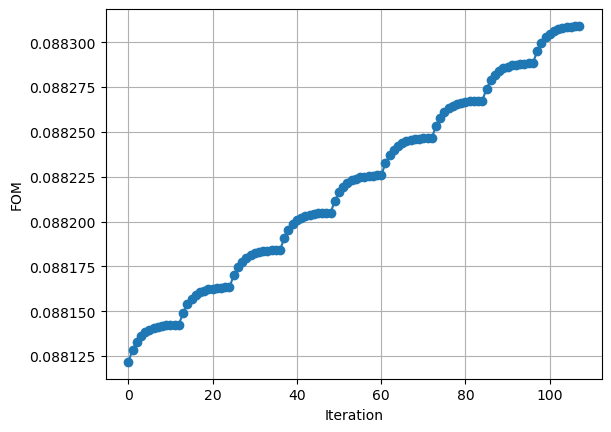

In [15]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

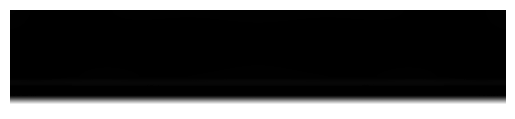

In [16]:
#opt[0].update_design([mapping(x, eta_i, cur_beta/beta_scale)]) # cur_beta/beta_scale is the final beta in the optimization.
plt.figure()
ax = plt.gca()
opt[0].plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

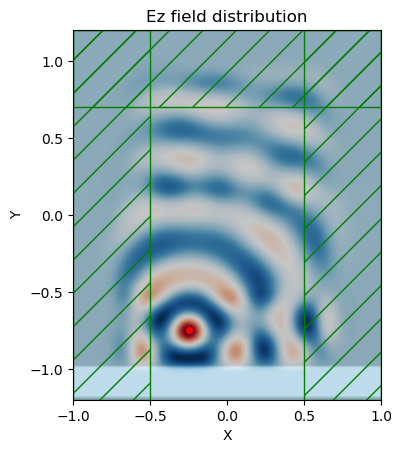

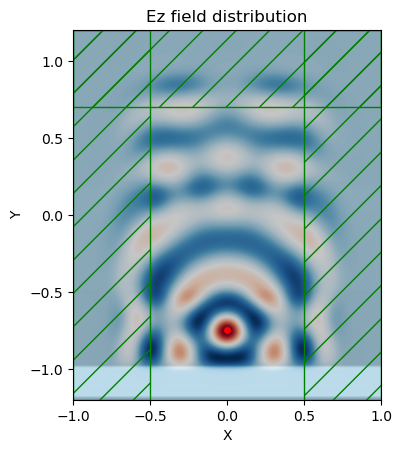

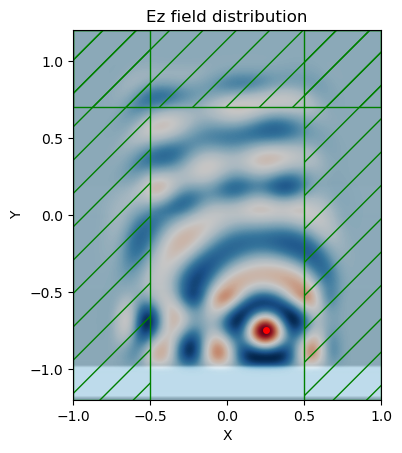

In [17]:
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = []
src_num = 3

for i in range(src_num):  # x 방향 루프
        source.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )
ppopt =[]
for i in range(src_num):
    ppopt.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[source[i]],
                      extra_materials=[ALU],)
    )

for i in range(src_num):
    ppopt[i].run(until=200)
    ppopt[i].plot2D(fields=mp.Ez) #, plot_sources_flag=False, plot_boundaries_flag=False, plot_monitors_flag=False)
    plt.title("Ez field distribution")
    plt.show()

In [18]:
flux_srcbox_top =[0]*src_num
flux_srcbox_bot =[0]*src_num
flux_srcbox_left =[0]*src_num
flux_srcbox_right =[0]*src_num

flux_glass =[0]*src_num
flux_wvgbox_right =[0]*src_num
flux_wvgbox_left =[0]*src_num

flux_total_srcbox =[0]*src_num
flux_total_glass =[0]*src_num
flux_waveguide =[0]*src_num

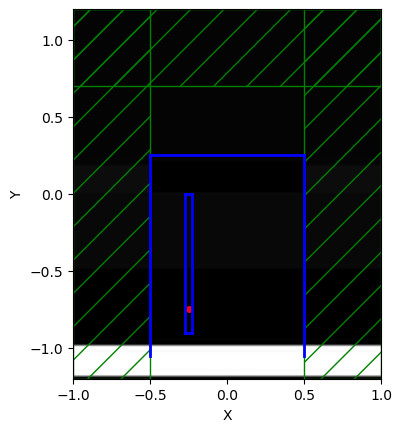

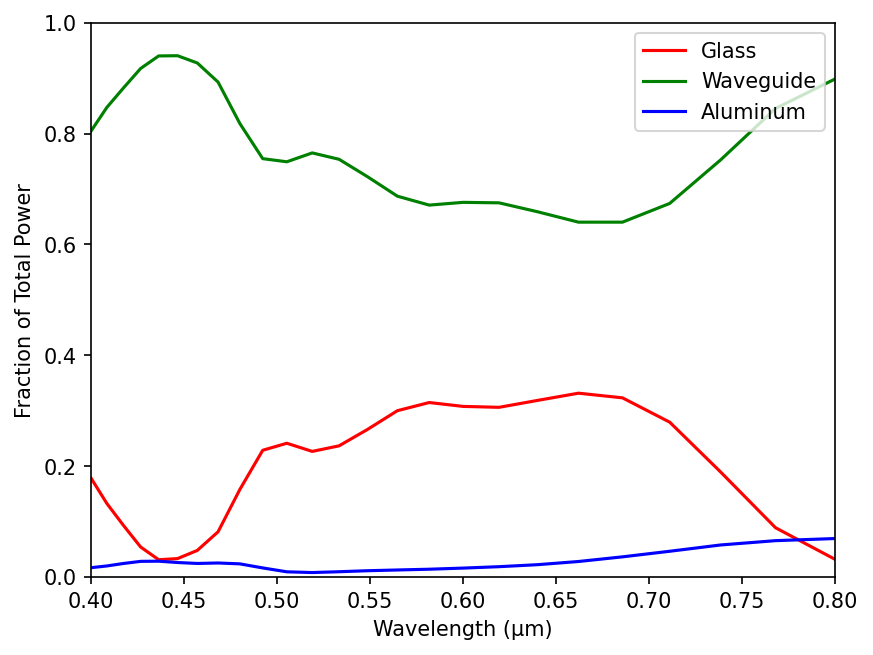

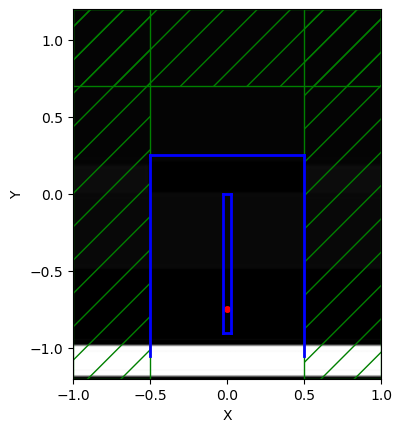

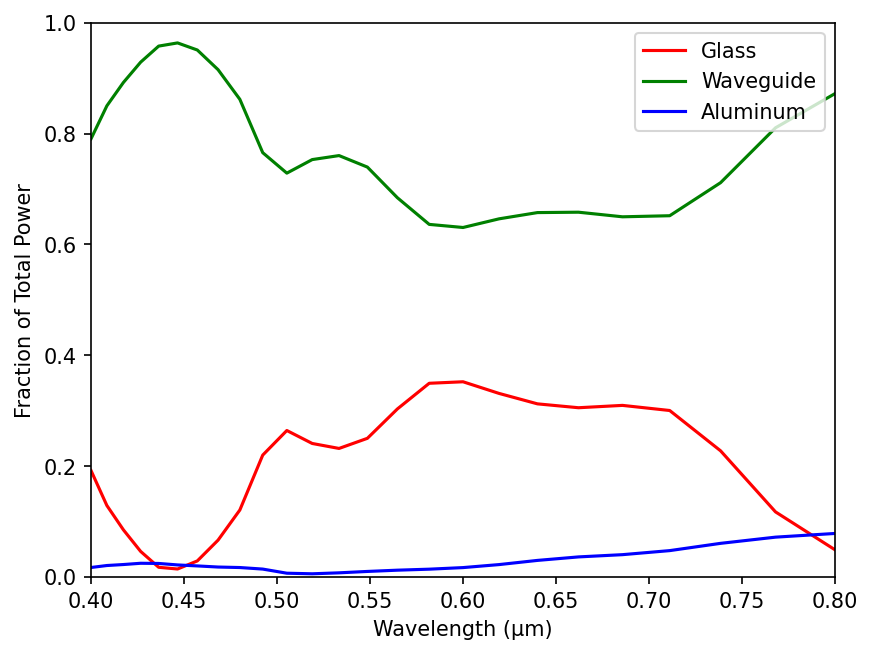

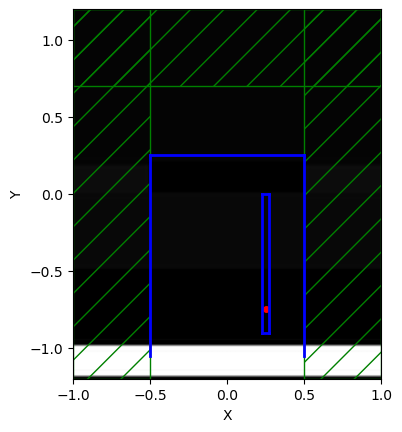

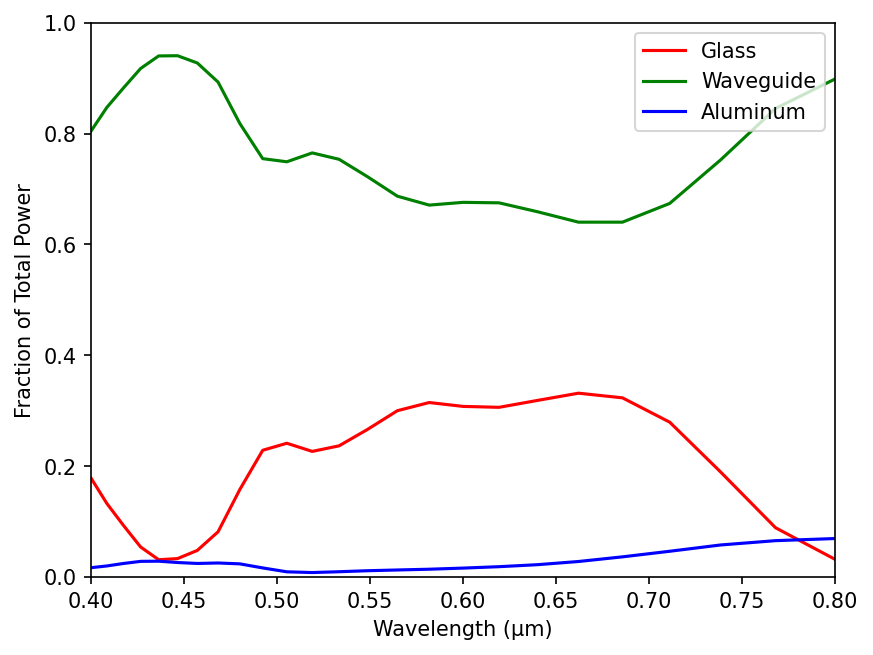

In [19]:
for i in range(src_num):
    ppopt[i].reset_meep()

    ppopt[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometry,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopt[i].sim.plot2D()

    ppopt[i].sim.run(until=100.0)

    flux_srcbox_top[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_bot[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_right[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_left[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glass[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_right[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_left[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcbox[i] = flux_srcbox_top[i] - flux_srcbox_bot[i] + flux_srcbox_right[i] - flux_srcbox_left[i]
    flux_total_glass[i] = flux_glass[i]
    flux_waveguide[i] = flux_wvgbox_right[i] - flux_wvgbox_left[i]

    wl = []
    gl = []
    wg = []
    al = []
    for d in range(nfreq):
        wl = np.append(wl, 1 / (flux_freqs[d]))
        gl = np.append(gl, flux_total_glass[i][d] / flux_total_srcbox[i][d])
        wg = np.append(wg, flux_waveguide[i][d] / flux_total_srcbox[i][d])
        al = 1 - gl - wg


    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, gl, "r", label="Glass")
        plt.plot(wl, wg, "g", label="Waveguide")
        plt.plot(wl, al, "b", label="Aluminum")

        
        plt.axis([0.40, 0.80, 0, 1])
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Fraction of Total Power")
        plt.legend(loc="upper right")
        plt.show()
        plt.cla()   # clear the current axes
        plt.clf()   # clear the current figure
        plt.close() # closes the current figure




In [20]:
geometryo = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=GLS,      # 디자인 영역
             size=mp.Vector3(mp.inf, design_region_height),
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

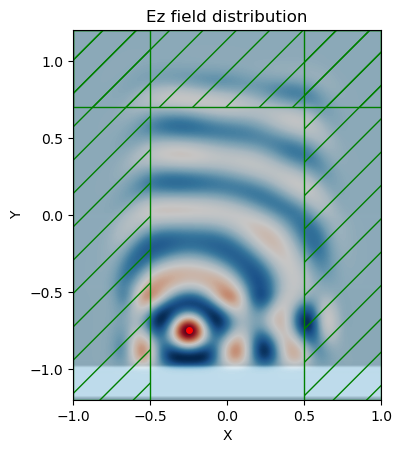

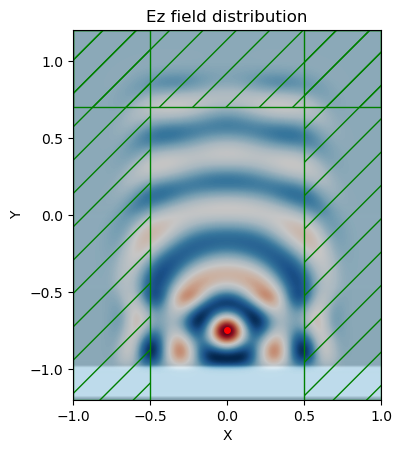

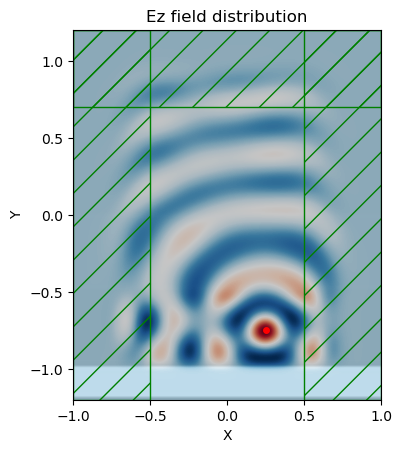

In [21]:
ppopto =[]
for i in range(src_num):
    ppopto.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometryo,
                      sources=[source[i]],
                      extra_materials=[ALU],)
    )

for i in range(src_num):
    ppopto[i].run(until=200)
    ppopto[i].plot2D(fields=mp.Ez) #, plot_sources_flag=False, plot_boundaries_flag=False, plot_monitors_flag=False)
    plt.title("Ez field distribution")
    plt.show()

In [22]:
flux_srcbox_topo =[0]*src_num
flux_srcbox_boto =[0]*src_num
flux_srcbox_lefto =[0]*src_num
flux_srcbox_righto =[0]*src_num

flux_glasso =[0]*src_num
flux_wvgbox_righto =[0]*src_num
flux_wvgbox_lefto =[0]*src_num

flux_total_srcboxo =[0]*src_num
flux_total_glasso =[0]*src_num
flux_waveguideo =[0]*src_num

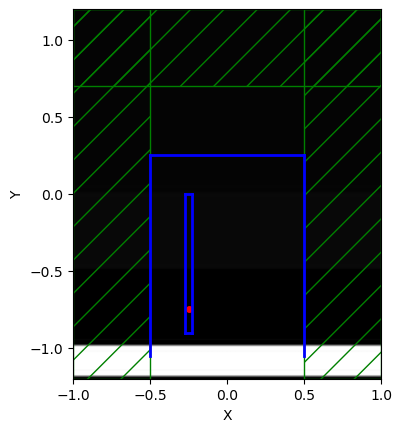

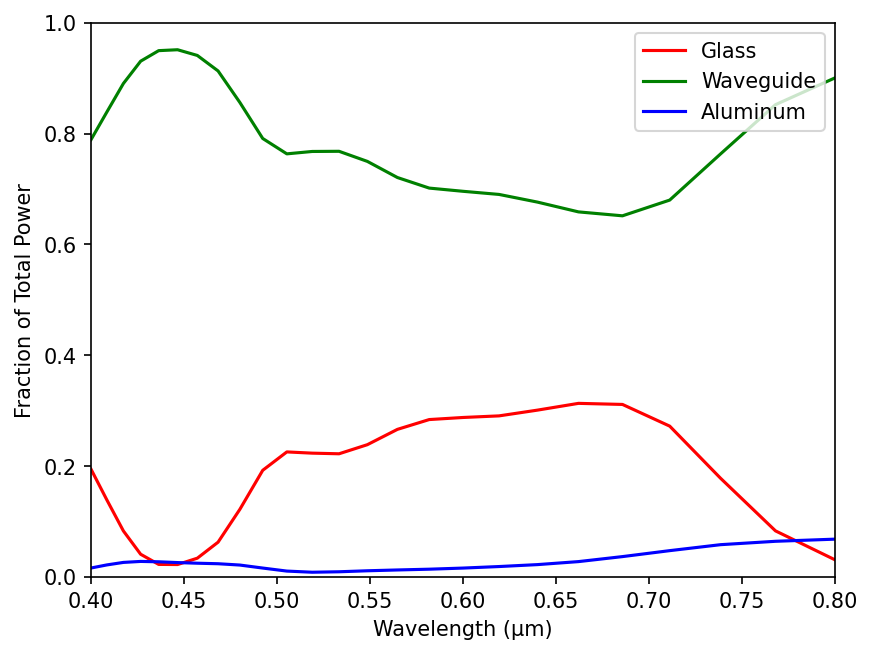

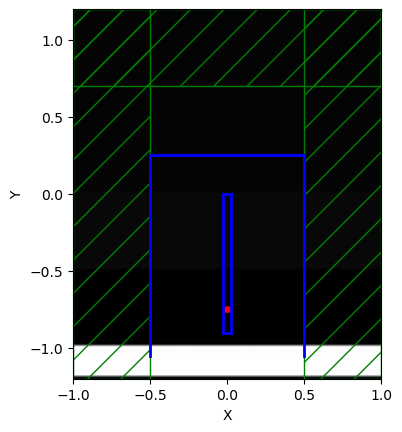

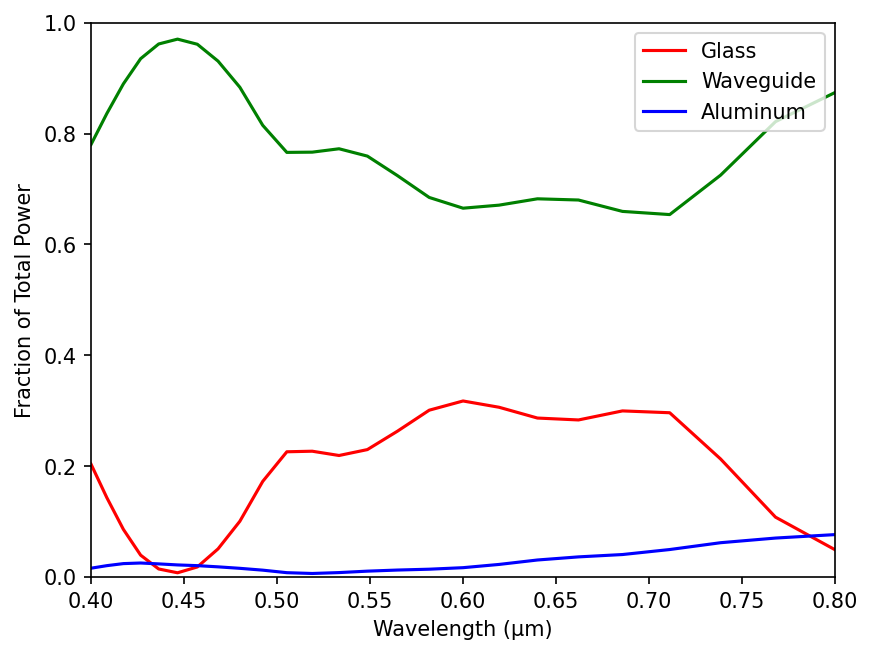

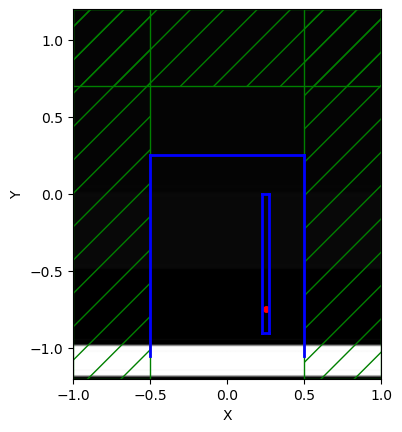

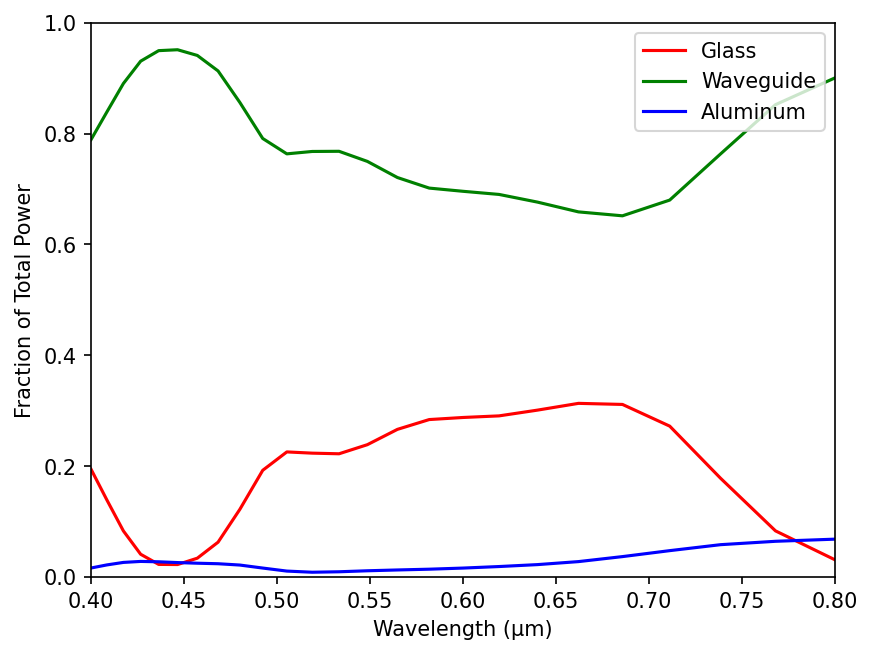

In [23]:
for i in range(src_num):
    ppopto[i].reset_meep()

    ppopto[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometryo,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopto[i].sim.plot2D()

    ppopto[i].sim.run(until=100.0)

    flux_srcbox_topo[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_boto[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_righto[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_lefto[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glasso[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_righto[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_lefto[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcboxo[i] = flux_srcbox_topo[i] - flux_srcbox_boto[i] + flux_srcbox_righto[i] - flux_srcbox_lefto[i]
    flux_total_glasso[i] = flux_glasso[i]
    flux_waveguideo[i] = flux_wvgbox_righto[i] - flux_wvgbox_lefto[i]

    wl = []
    gl = []
    wg = []
    al = []
    for d in range(nfreq):
        wl = np.append(wl, 1 / (flux_freqs[d]))
        gl = np.append(gl, flux_total_glasso[i][d] / flux_total_srcboxo[i][d])
        wg = np.append(wg, flux_waveguideo[i][d] / flux_total_srcboxo[i][d])
        al = 1 - gl - wg


    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, gl, "r", label="Glass")
        plt.plot(wl, wg, "g", label="Waveguide")
        plt.plot(wl, al, "b", label="Aluminum")

        
        plt.axis([0.40, 0.80, 0, 1])
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Fraction of Total Power")
        plt.legend(loc="upper right")
        plt.show()
        plt.cla()   # clear the current axes
        plt.clf()   # clear the current figure
        plt.close() # closes the current figure

In [24]:
flux_srcbox_top_s =[0]*src_num
flux_srcbox_bot_s =[0]*src_num
flux_srcbox_left_s =[0]*src_num
flux_srcbox_right_s =[0]*src_num

flux_glass_s =[0]*src_num
flux_wvgbox_right_s =[0]*src_num
flux_wvgbox_left_s =[0]*src_num

flux_total_srcbox_s =[0]*src_num
flux_total_glass_s =[0]*src_num
flux_waveguide_s =[0]*src_num

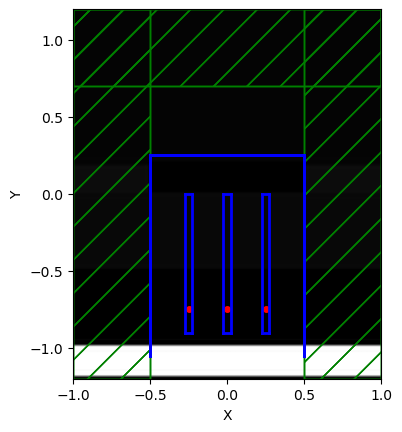

In [25]:
for i in range(src_num):
    ppopt[i].reset_meep()

    ppopt[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometry,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopt[i].sim.plot2D()

    ppopt[i].sim.run(until=100.0)

    flux_srcbox_top_s[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_bot_s[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_right_s[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_left_s[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glass_s[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_right_s[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_left_s[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcbox_s[i] = flux_srcbox_top_s[i] - flux_srcbox_bot_s[i] + flux_srcbox_right_s[i] - flux_srcbox_left_s[i]
    flux_total_glass_s[i] = flux_glass_s[i]
    flux_waveguide_s[i] = flux_wvgbox_right_s[i] - flux_wvgbox_left_s[i]



In [26]:
flux_srcbox_topo_s =[0]*src_num
flux_srcbox_boto_s =[0]*src_num
flux_srcbox_lefto_s =[0]*src_num
flux_srcbox_righto_s =[0]*src_num

flux_glasso_s =[0]*src_num
flux_wvgbox_righto_s =[0]*src_num
flux_wvgbox_lefto_s =[0]*src_num

flux_total_srcboxo_s =[0]*src_num
flux_total_glasso_s =[0]*src_num
flux_waveguideo_s =[0]*src_num

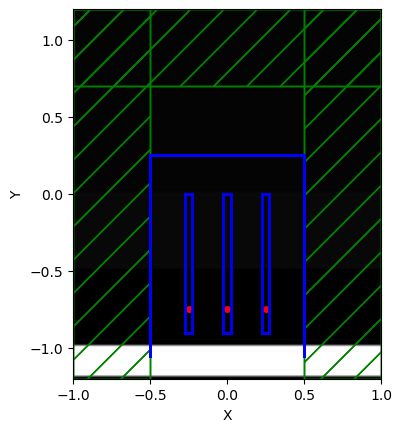

In [27]:
for i in range(src_num):
    ppopto[i].reset_meep()

    ppopto[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometryo,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopto[i].sim.plot2D()

    ppopto[i].sim.run(until=100.0)

    flux_srcbox_topo_s[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_boto_s[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_righto_s[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_lefto_s[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glasso_s[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_righto_s[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_lefto_s[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcboxo_s[i] = flux_srcbox_topo_s[i] - flux_srcbox_boto_s[i] + flux_srcbox_righto_s[i] - flux_srcbox_lefto_s[i]
    flux_total_glasso_s[i] = flux_glasso_s[i]
    flux_waveguideo_s[i] = flux_wvgbox_righto_s[i] - flux_wvgbox_lefto_s[i]


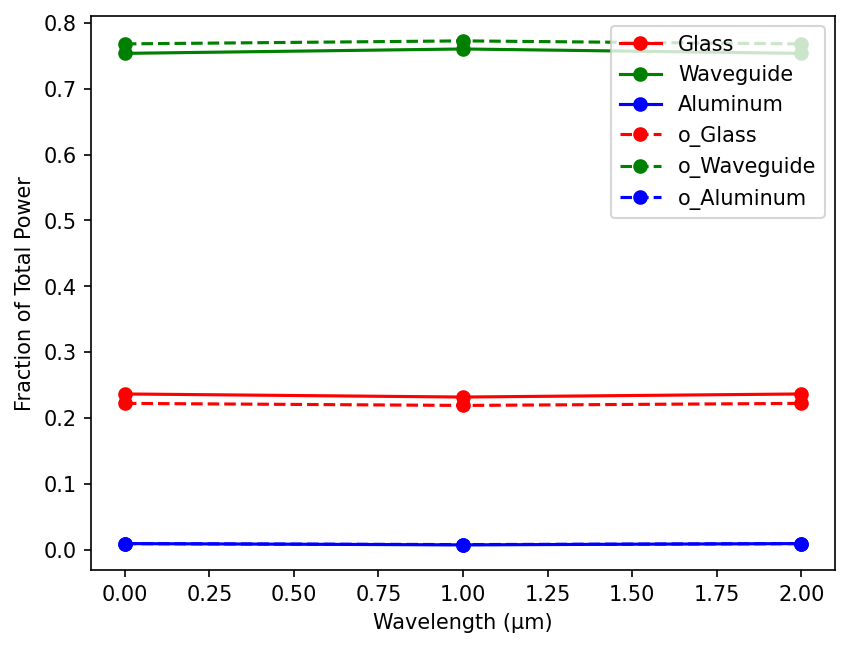

In [28]:
wl = []
gl = []
wg = []
al = []
o_gl = []
o_wg = []
o_al = []
for d in range(src_num):
    wl = np.append(wl, d)
    gl = np.append(gl, flux_total_glass_s[d] / flux_total_srcbox_s[d])
    wg = np.append(wg, flux_waveguide_s[d] / flux_total_srcbox_s[d])
    al = 1 - gl - wg
    o_gl = np.append(o_gl, flux_total_glasso_s[d] / flux_total_srcboxo_s[d])
    o_wg = np.append(o_wg, flux_waveguideo_s[d] / flux_total_srcboxo_s[d])
    o_al = 1 - o_gl - o_wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r-o", label="Glass")
    plt.plot(wl, wg, "g-o", label="Waveguide")
    plt.plot(wl, al, "b-o", label="Aluminum")
    plt.plot(wl, o_gl, "r--o", label="o_Glass")
    plt.plot(wl, o_wg, "g--o", label="o_Waveguide")
    plt.plot(wl, o_al, "b--o", label="o_Aluminum")

    
    # plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure